# Protein Level Analysis

In [1]:
library(readxl)
library(sets)
library(tidyverse)
library(limma)
library(gplots)
library(ggplot2)
library(dplyr)
library(ROSE)
library(scutr)

# set working directory
setwd('/lustre/home/reynaj/Projects/20241011.Byrd_Lab.IBD_NuLisa')

# set the output directory
datadir <- "results/aggregated/comp_data/"

# set the output directory
outdir <- "results/aggregated/limma/"

# set global values
da_levels <- c('N/A (Non-IBD Control)', 'Quiescent', 'Mild', 'Moderate')
highlight_genes <- list(list(name = "IL36B", color = "green"))
save_flag <- TRUE

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ forcats::%>%()           masks stringr::%>%(), dplyr::%>%(), purrr::%>%(), tidyr::%>%(), tibble::%>%(), sets::%>%()
✖ lubridate::as.interval() masks sets::as.interval()
✖ dplyr::filter()          masks stats::filter()
✖ lubridate::interval()    masks sets::interval()
✖ lubridate::is.interval() masks sets::is.interval()
✖ dplyr::lag()             masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess


Loaded ROSE 0.0-4




## Load the datasets

In [2]:
fn = file.path(datadir, "protein_levels.npq.tsv")
protein_data <- read.table(fn, header=TRUE, check.names=FALSE, sep = "\t")

fn = file.path(datadir, "clinical_data.tsv")
clinical_data <- read.table(fn, header=TRUE, sep="\t")
clinical_data$matched_subject_id <- as.character(clinical_data$matched_subject_id) 

# remove alamar samples completely
clinical_data <- clinical_data[clinical_data$ibd_diagnosis != "Alamar_Sample_Control",] 
protein_data <- protein_data[, colnames(protein_data) != 999]

## Run limma for IBD subtypes with control as the anchor (all data)

In [3]:
# set groups and design
group <- factor(clinical_data$ibd_diagnosis, levels=c("Control", "CD", "UC", "IBD-U"))
design <- model.matrix(~ group)

# # fit linear model for data
fit <- lmFit(protein_data, design)

# apply empirical bayes
fit <- eBayes(fit)

# get results
results_cd <- topTable(fit, adjust="BH", coef="groupCD", number=Inf)
results_uc <- topTable(fit, adjust="BH", coef="groupUC", number=Inf)
results_ibdu <- topTable(fit, adjust="BH", coef="groupIBD-U", number=Inf)

# get reorganized results results
binary_results <- decideTests(fit, method="global", adjust.method="BH")
binary_results <- as.data.frame(binary_results)

### Visualize the results

In [4]:
create_volcano_plot_v2 <- function(results, topn=10, highlight_genes=NULL, filename='', save=FALSE) {
    
  # Create a logical column for significance
  results$significant <- results$P.Value <= 0.05
  
  # Identify the top 10 genes based on P.Value
  top_genes <- results %>%
    arrange(P.Value) %>%
    slice_head(n = topn)
  
  # Create a new column for color based on logFC
  results$color <- ifelse(results$significant & results$logFC < 0, "blue", 
                          ifelse(results$significant & results$logFC > 0, "red", "grey"))
  
  # If highlight_genes is provided, update the color and zorder
  if (!is.null(highlight_genes)) {
    for (gene in highlight_genes) {
      results$color[rownames(results) == gene$name] <- gene$color
      results$size[rownames(results) == gene$name] <- 4  # Increase size for highlighted gene
    }
  }
  
  # Create the volcano plot
  p <- ggplot(results, aes(x = logFC, y = -log10(P.Value), color = color)) +
    geom_point(aes(size = ifelse(rownames(results) %in% highlight_genes$name, 4, 2)), 
               alpha = 0.6) +
    scale_color_identity() +  # Use the colors defined in the data
    theme_minimal() +
    labs(title = "", x = "Log2 Fold Change (logFC)", y = "-Log10 P-value") +
    theme(legend.position = "none",
          panel.background = element_rect(fill = "white", color = NA),
          plot.background = element_rect(fill = "white", color = NA)) +  # Hide legend if not needed
    geom_text(data = top_genes, aes(label = rownames(top_genes)), 
              vjust = -0.5, hjust = 0.5, size = 3, color = "black") +  # Annotate top 10 genes
    geom_point(data = results[results$rownames %in% highlight_genes$name, ], 
               aes(x = logFC, y = -log10(P.Value)), 
               color = highlight_genes$color, size = 4, alpha = 1, 
               position = position_jitter(width = 0.1, height = 0.1))  # Higher z-order for highlighted genes
    
    if (save == TRUE){
        ggsave(filename, plot = p, width = 8, height = 6)
    }
    return(p)
}


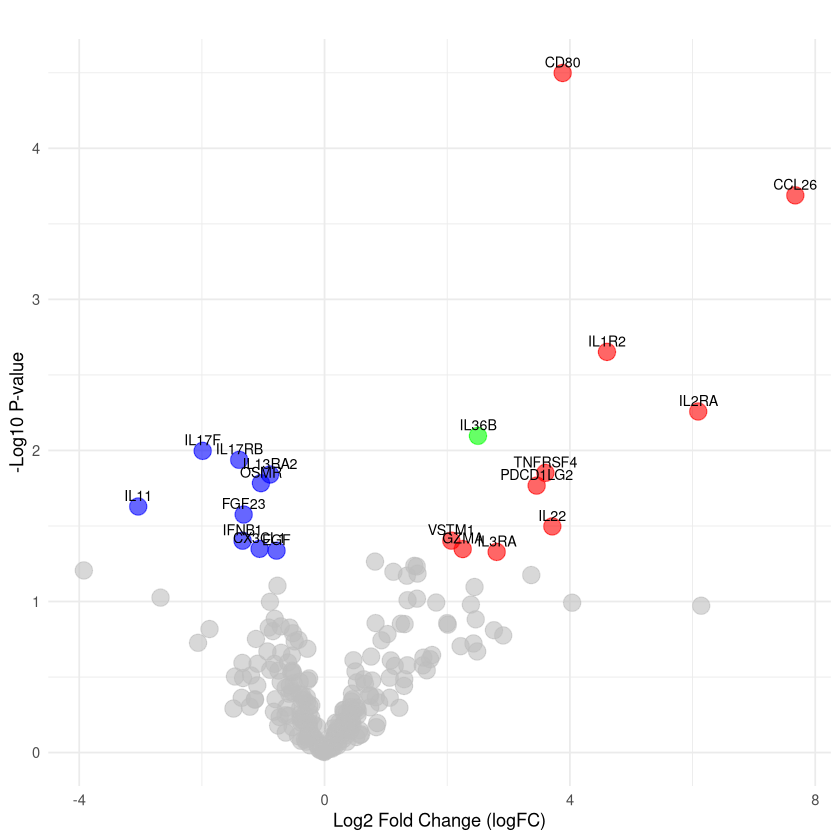

In [5]:
fn = file.path(outdir, "limma.all_data.ibd_subtypes.control_versus_cd.png")
p <- create_volcano_plot_v2(results_cd, topn=20, highlight_genes=highlight_genes, filename=fn, save=save_flag); p

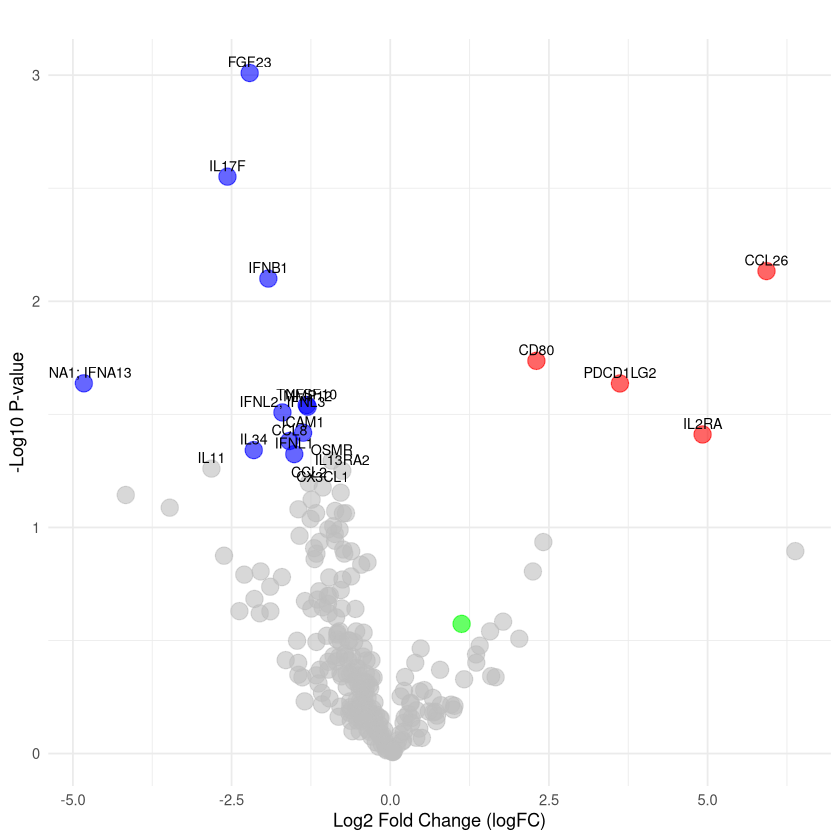

In [6]:
fn = file.path(outdir, "limma.all_data.ibd_subtypes.control_versus_uc.png")
p <- create_volcano_plot_v2(results_uc, topn=20, highlight_genes=highlight_genes, filename=fn, save=save_flag); p

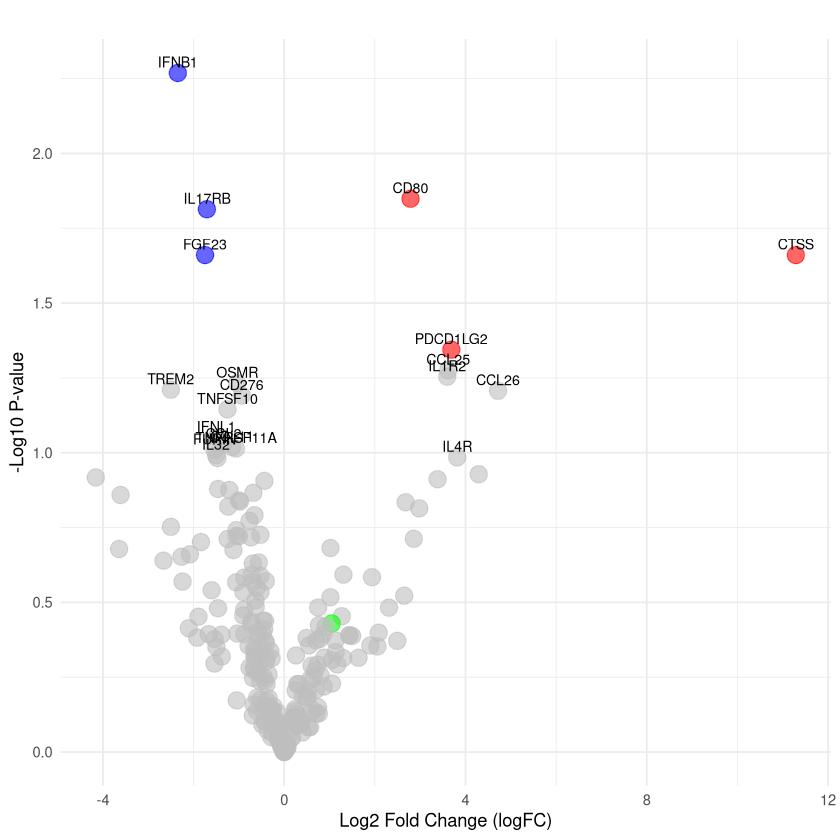

In [7]:
fn = file.path(outdir, "limma.all_data.ibd_subtypes.control_versus_ibdu.png")
p <- create_volcano_plot_v2(results_ibdu, topn=20, highlight_genes=highlight_genes, filename=fn, save=save_flag); p

In [8]:
# Draw venn diagram of results
#vennDiagram(decideTests(fit, method="global", adjust.method="BH"))

## Run limma for disease activity (all data)

In [9]:
# set groups and design
group <- factor(clinical_data$disease_activity, levels=da_levels)
design <- model.matrix(~ group)

# # fit linear model for data
fit <- lmFit(protein_data, design)

# apply empirical bayes
fit <- eBayes(fit)

# get results
results_qu <- topTable(fit, adjust="BH", coef="groupQuiescent", number=Inf)
#results_qu <- cbind(protein=rownames(results_qu), results_qu)

results_mild <- topTable(fit, adjust="BH", coef="groupMild", number=Inf)
#results_mild <- cbind(protein=rownames(results_mild), results_mild)

results_mod <- topTable(fit, adjust="BH", coef="groupModerate", number=Inf)
#results_mod <- cbind(protein=rownames(results_mod), results_mod)

# get reorganized results results
binary_results <- decideTests(fit, method="global", adjust.method="BH")
binary_results <- as.data.frame(binary_results)

In [10]:
outfn = file.path(outdir, "limma.all_data.disease_activity.control_versus_quiescent.tsv")
write.table(results_qu, file = outfn, sep="\t", col.names=TRUE, quote=FALSE)

outfn = file.path(outdir, "limma.all_data.disease_activity.control_versus_mild.tsv")
write.table(results_mild, file = outfn, sep="\t", col.names=TRUE, quote=FALSE)

outfn = file.path(outdir, "limma.all_data.disease_activity.control_versus_moderate.tsv")
write.table(results_mod, file = outfn, sep="\t", col.names=TRUE, quote=FALSE)

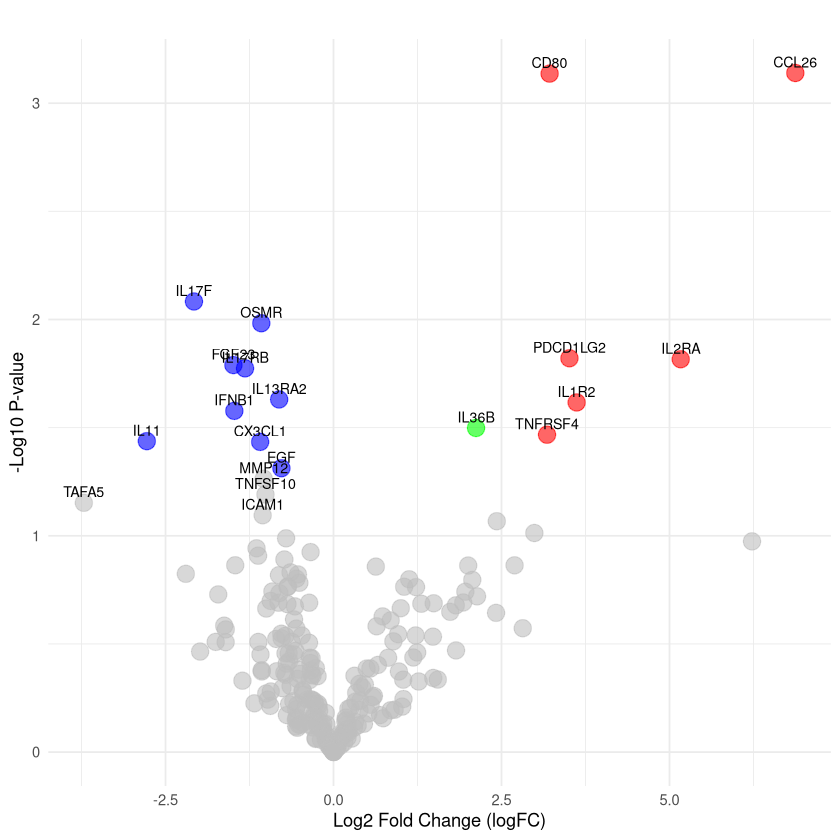

In [11]:
fn = file.path(outdir, "limma.all_data.disease_activity.control_versus_quiescent.png")
p <- create_volcano_plot_v2(results_qu, topn=20, highlight_genes=highlight_genes, filename=fn, save=save_flag); p

In [12]:
data.matrix(results_qu["IL36B",])

,logFC,AveExpr,t,P.Value,adj.P.Val,B
IL36B,2.121102,16.37157,2.199422,0.0317398,0.6134569,-3.820081


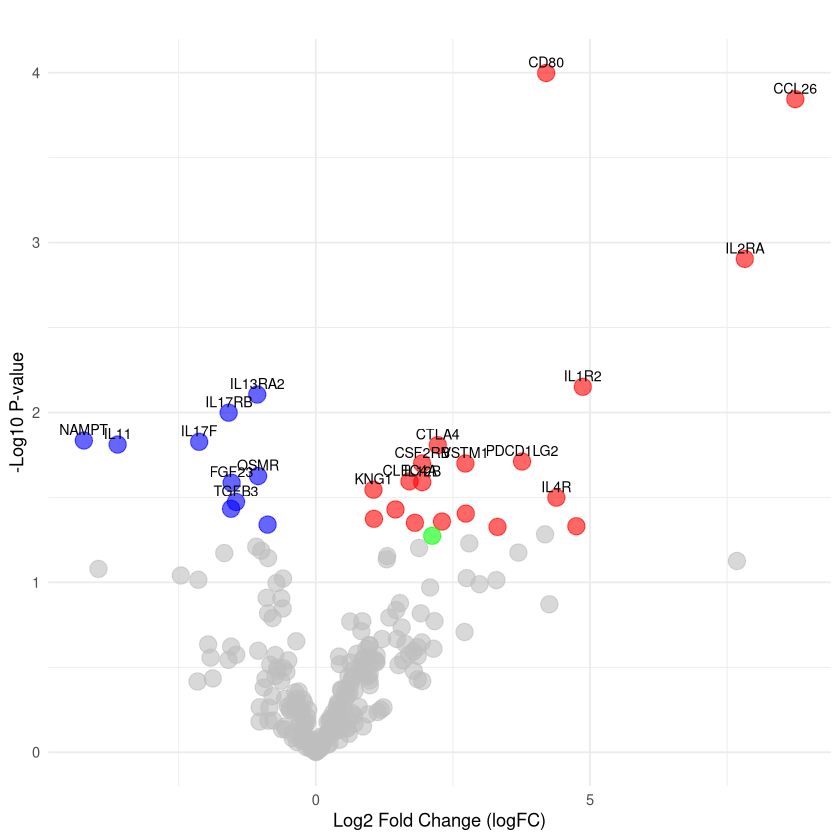

In [13]:
fn = file.path(outdir, "limma.all_data.disease_activity.control_versus_mild.png")
p <- create_volcano_plot_v2(results_mild, topn=20, highlight_genes=highlight_genes, filename=fn, save=save_flag); p

In [14]:
data.matrix(results_mild["IL36B",])

,logFC,AveExpr,t,P.Value,adj.P.Val,B
IL36B,2.122315,16.37157,1.97225,0.05322783,0.4292567,-4.278416


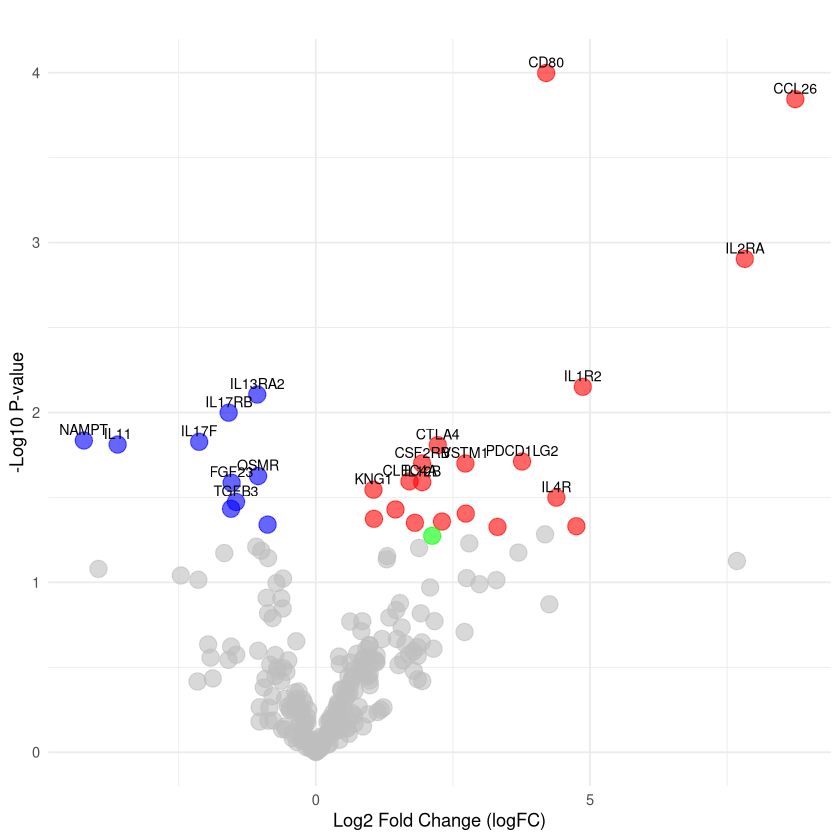

In [15]:
fn = file.path(outdir, "limma.all_data.disease_activity.control_versus_moderate.png")
p <- create_volcano_plot_v2(results_mild, topn=20, highlight_genes=highlight_genes, filename=fn, save=save_flag); p

In [16]:
data.matrix(results_mod["IL36B",])

,logFC,AveExpr,t,P.Value,adj.P.Val,B
IL36B,1.58786,16.37157,1.218424,0.2278653,0.9835338,-4.592238


### Indicator version

In [17]:
# Draw venn diagram of results
# vennDiagram(decideTests(fit, method="global", adjust.method="BH"))

In [18]:
# set groups and design
group <- factor(clinical_data$disease_activity_indicator, levels=c("In-active Disease", "Active Disease"))
design <- model.matrix(~ group)

# # fit linear model for data
fit <- lmFit(protein_data, design)

# apply empirical bayes
fit <- eBayes(fit)

# get results
results_da <- topTable(fit, adjust="BH", coef="groupActive Disease", number=Inf)

# get reorganized results results
binary_results <- decideTests(fit, method="global", adjust.method="BH")
binary_results <- as.data.frame(binary_results)

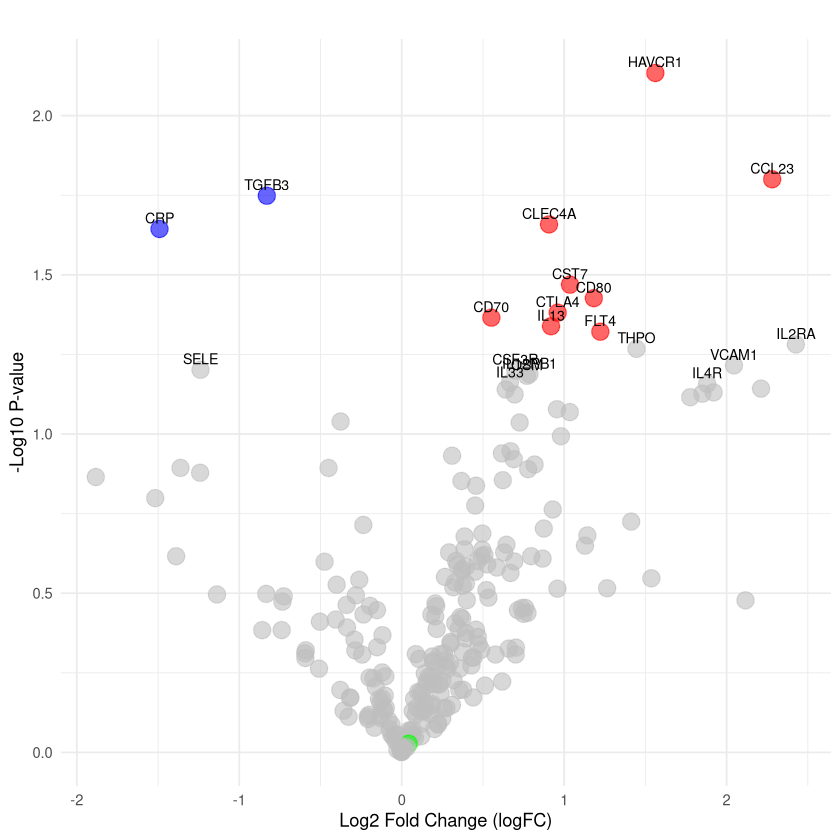

In [19]:
fn = file.path(outdir, "limma.all_data.disease_activity_indicator.inactive_versus_active.png")
p <- create_volcano_plot_v2(results_da, topn=20, highlight_genes=highlight_genes, filename=fn, save=save_flag); p

# Draw venn diagram of results
# vennDiagram(decideTests(fit, method="global", adjust.method="BH"))

### Investigating Protein Levels One at a Time

In [20]:
temp_protein_data <- t(protein_data)
combined_data = data.frame(temp_protein_data, disease_activity=factor(clinical_data$disease_activity, levels=da_levels))

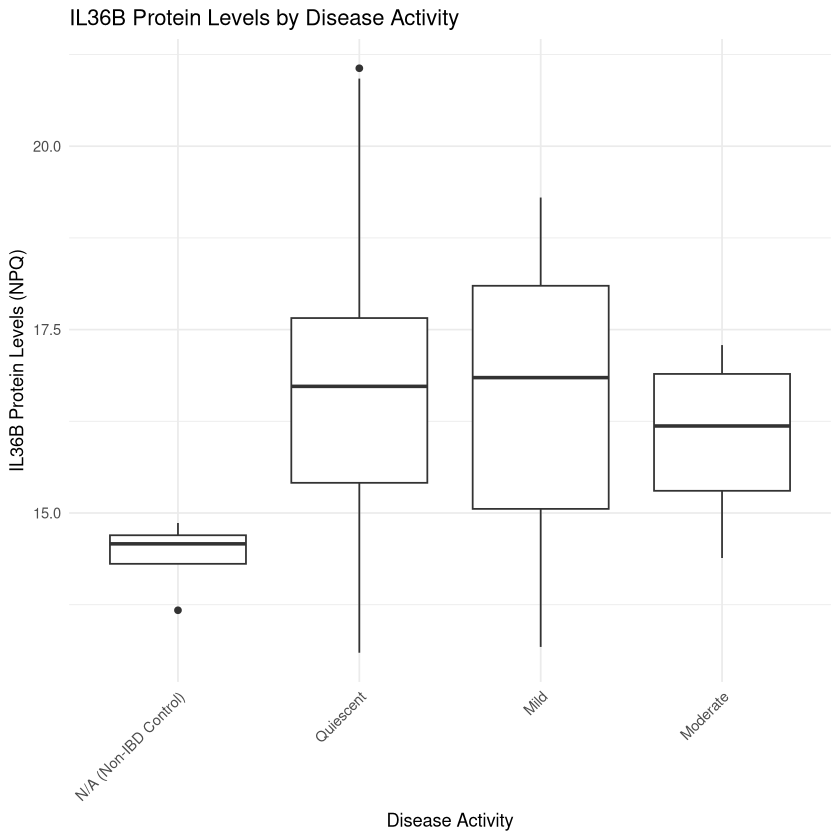

In [21]:
# Create the boxplot
ggplot(combined_data, aes(x=disease_activity, group = disease_activity, y = IL36B)) +
  geom_boxplot() +
  labs(title = "IL36B Protein Levels by Disease Activity",
       x = "Disease Activity",
       y = "IL36B Protein Levels (NPQ)") +
  theme_minimal() + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1))


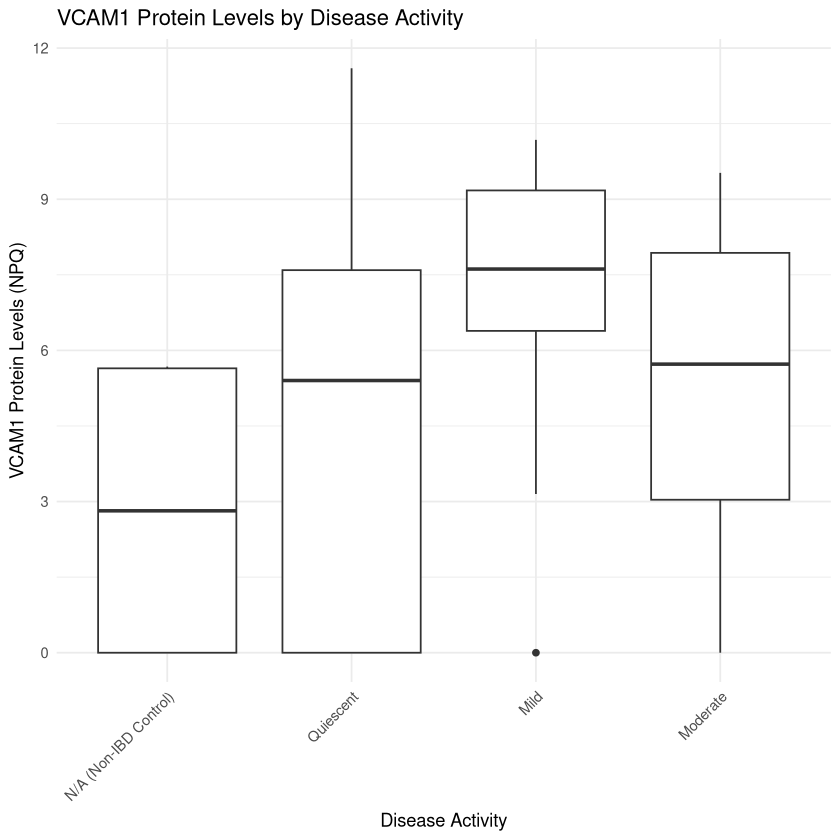

In [22]:
# Create the boxplot
ggplot(combined_data, aes(x=disease_activity, group = disease_activity, y = VCAM1)) +
  geom_boxplot() +
  labs(title = "VCAM1 Protein Levels by Disease Activity",
       x = "Disease Activity",
       y = "VCAM1 Protein Levels (NPQ)") +
  theme_minimal() + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1))


## Run limma for disease activity (all data, testing resampling approach)

In [23]:
# # Combine data
# temp_protein_data <- t(protein_data)
# combined_data <- data.frame(temp_protein_data, disease_activity = clinical_data$disease_activity)

# # Apply SCUT
# scutted <- SCUT(combined_data, "disease_activity", oversample = oversample_smote)
# curr_clinical_data <- scutted[, "disease_activity"]
# curr_protein_data <- t(subset(scutted, select = -c(disease_activity)))

In [24]:
# # set groups and design
# group <- factor(curr_clinical_data, levels=c("In-active Disease", "Active Disease"))
# design <- model.matrix(~ group)

# # # fit linear model for data
# fit <- lmFit(curr_protein_data, design)

# # apply empirical bayes
# fit <- eBayes(fit)

# # get results
# results_da <- topTable(fit, adjust="BH", coef="groupActive Disease", number=Inf)

# # get reorganized results results
# binary_results <- decideTests(fit, method="global", adjust.method="BH")
# binary_results <- as.data.frame(binary_results)

In [25]:
#create_volcano_plot_v2(results_da, topn=20)

# Draw venn diagram of results
# vennDiagram(decideTests(fit, method="global", adjust.method="BH"))

## Run limma for disease activity indicator with CD data only

In [26]:
crohn_clinical_data <- clinical_data[clinical_data$ibd_diagnosis == "CD",]
crohn_protein_data <- protein_data[, crohn_clinical_data$matched_subject_id]

# set groups and design
group <- factor(crohn_clinical_data$disease_activity_indicator, levels=c("In-active Disease", "Active Disease"))
design <- model.matrix(~ group)

# # fit linear model for data
fit <- lmFit(crohn_protein_data, design)

# apply empirical bayes
fit <- eBayes(fit)

# get results
results_da <- topTable(fit, adjust="BH", coef="groupActive Disease", number=Inf)

# get reorganized results results
binary_results <- decideTests(fit, method="global", adjust.method="BH")
binary_results <- as.data.frame(binary_results)


### Visualize the results

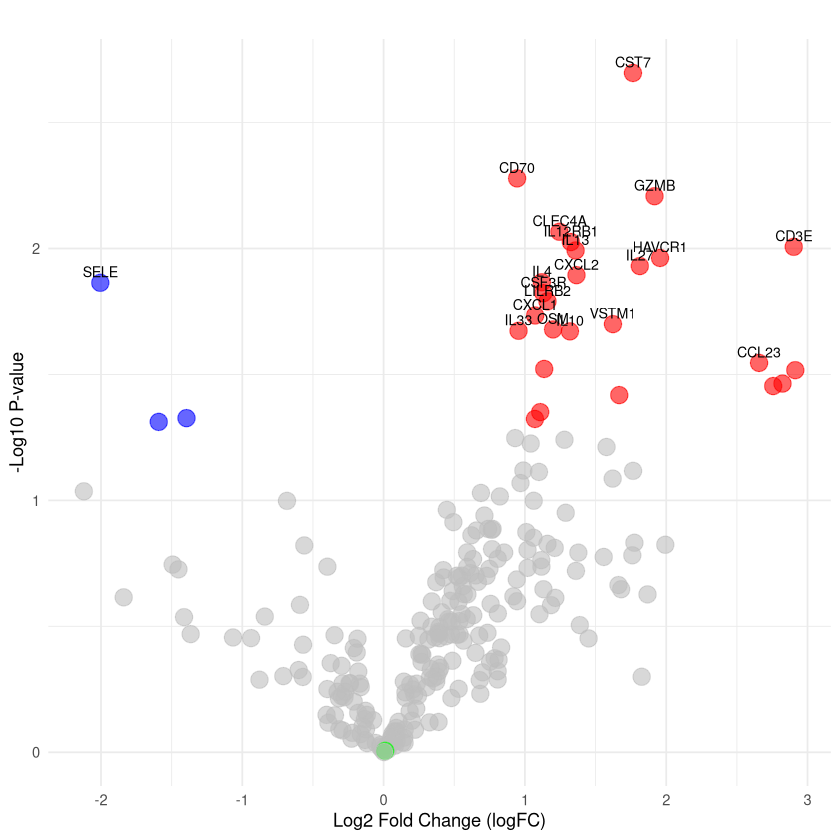

In [27]:
fn = file.path(outdir, "limma.crohn_data.disease_activity_indicator.inactive_versus_active.png")
p <- create_volcano_plot_v2(results_da, topn=20, highlight_genes=highlight_genes, filename=fn, save=save_flag); p

# Draw venn diagram of results
# vennDiagram(decideTests(fit, method="global", adjust.method="BH"))

## Run Limma for disease activity indicator with UC data only

In [28]:
uc_clinical_data <- clinical_data[clinical_data$ibd_diagnosis == "UC",]
uc_protein_data <- protein_data[, uc_clinical_data$matched_subject_id]

# set groups and design
group <- factor(uc_clinical_data$disease_activity_indicator, levels=c("In-active Disease", "Active Disease"))
design <- model.matrix(~ group)

# # fit linear model for data
fit <- lmFit(uc_protein_data, design)

# apply empirical bayes
fit <- eBayes(fit)

# get results
results_da <- topTable(fit, adjust="BH", coef="groupActive Disease", number=Inf)

# get reorganized results results
binary_results <- decideTests(fit, method="global", adjust.method="BH")
binary_results <- as.data.frame(binary_results)

### Visualize the results

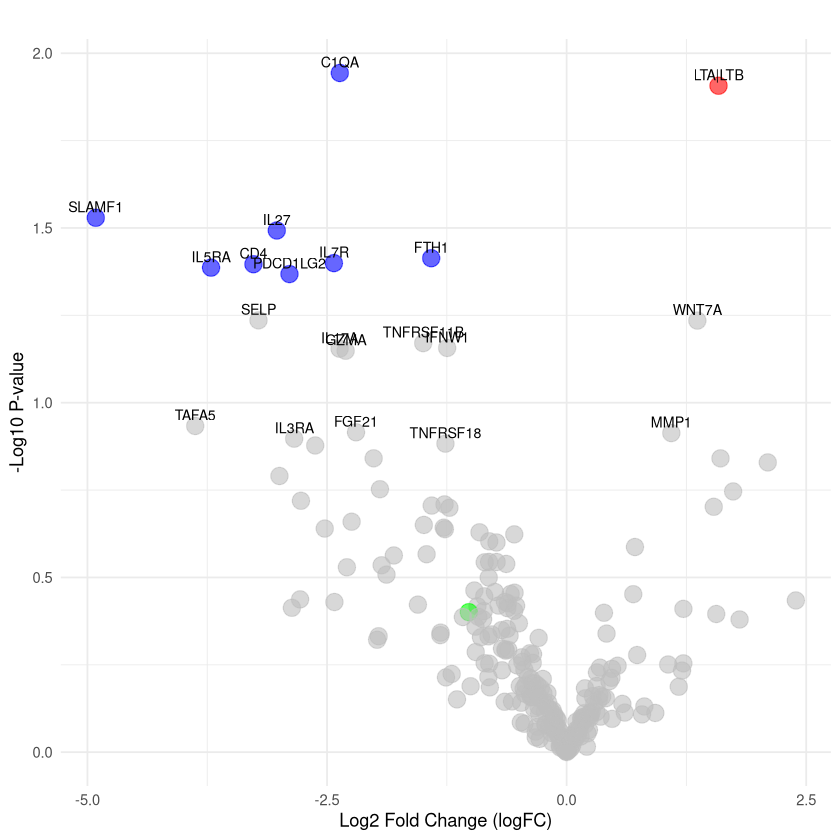

In [29]:
fn = file.path(outdir, "limma.ulcerative_colitis_data.disease_activity_indicator.inactive_versus_active.png")
p <- create_volcano_plot_v2(results_da, topn=20, highlight_genes=highlight_genes, filename=fn, save=save_flag); p

# Draw venn diagram of results
#vennDiagram(decideTests(fit, method="global", adjust.method="BH"))